# Data Cleaning

Our first strategy to figure out how to clean the data was to simply look at it in an excel spreadsheet. 
Here are some things we noticed:
* Lots of the categories are non-numerical (breed, climate zone, management system, date, etc.)
* lots of numerical values start with a "'"
* Some negative values don't make sense (rumination time)
* Some blank values
* Feed quantity is present twice

In [200]:
# imports 

import pandas as pd 
import sklearn 
import matplotlib as plt

In [201]:
# read in the data
data = pd.read_csv("cattle_data_train.csv")
test = pd.read_csv("cattle_data_test.csv")
labels = data.iloc()[:, -1]
data.head()

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,Resting_Hours,Ambient_Temperature_C,Humidity_percent,Housing_Score,FMD_Vaccine,Brucellosis_Vaccine,HS_Vaccine,BQ_Vaccine,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis,Milk_Yield_L
0,CATTLE_133713,Holstein,Tropical,Intensive,114,544.8,4,Mid,62,Concentrates,16.363455,2,71.101024,4.77,7.8,-2.269369,12.3,28.706090,70.6,0.871430,0,1,1,0,0,1,0,1,6.31,3.0,12,2024-01-15,FARM_0301,36.8235,1,12.192634
1,CATTLE_027003,Holstein,Arid,Mixed,136,298.9,4,Mid,213,Crop_Residues,NaN,4,55.697328,5.99,7.4,8.973851,11.4,28.599741,57.5,0.825488,1,1,0,1,0,0,0,0,17.16,4.0,12,2023-10-31,FARM_0219,NaN,0,14.717031
2,CATTLE_122459,Holstein,Tropical,Semi_Intensive,64,336.6,4,Late,16,Hay,7.198607,2,65.576827,3.45,8.8,-4.590550,8.6,12.520386,51.2,0.904957,0,0,1,1,0,1,1,0,4.07,3.5,12,2024-05-20,FARM_0802,16.0965,0,14.006142
3,CATTLE_213419,Jersey,Mediterranean,Intensive,58,370.5,1,Early,339,Crop_Residues,18.694344,2,71.238287,5.95,6.5,1.792698,10.1,40.510261,57.9,0.324955,1,0,1,0,1,0,0,0,10.23,3.0,24,2024-07-22,FARM_0034,40.7925,0,24.324325
4,CATTLE_106260,Guernsey,Subtropical,Intensive,84,641.5,6,Early,125,Mixed_Feed,14.779198,4,46.979548,5.39,6.4,12.621422,9.3,-7.711288,73.2,0.871019,0,1,1,1,1,0,1,1,20.68,3.0,12,2023-01-03,FARM_0695,33.7365,1,12.023074


In [202]:
# checking which columns have missing values
data.isna().sum()

Cattle_ID                      0
Breed                          0
Climate_Zone                   0
Management_System              0
Age_Months                     0
Weight_kg                      0
Parity                         0
Lactation_Stage                0
Days_in_Milk                   0
Feed_Type                      0
Feed_Quantity_kg           10481
Feeding_Frequency              0
Water_Intake_L                 0
Walking_Distance_km            0
Grazing_Duration_hrs           0
Rumination_Time_hrs            0
Resting_Hours                  0
Ambient_Temperature_C          0
Humidity_percent               0
Housing_Score               6279
FMD_Vaccine                    0
Brucellosis_Vaccine            0
HS_Vaccine                     0
BQ_Vaccine                     0
Anthrax_Vaccine                0
IBR_Vaccine                    0
BVD_Vaccine                    0
Rabies_Vaccine                 0
Previous_Week_Avg_Yield        0
Body_Condition_Score           0
Milking_In

In [203]:
# Number of unique values in each column

# data.apply(lambda s: s.duplicated().sum())
data.apply(lambda s: s.value_counts().gt(1).sum())
print(data["Breed"].unique()) # found that some names are wrong for the cows
data["Breed"] = data["Breed"].replace("Holstien", "Holstein")
data["Breed"] = data["Breed"].str.strip()
print(data.head())


['Holstein' 'Jersey' 'Guernsey' 'Brown Swiss' ' Brown Swiss' 'Holstien'
 'Brown Swiss ']
       Cattle_ID     Breed   Climate_Zone Management_System  Age_Months  \
0  CATTLE_133713  Holstein       Tropical         Intensive         114   
1  CATTLE_027003  Holstein           Arid             Mixed         136   
2  CATTLE_122459  Holstein       Tropical    Semi_Intensive          64   
3  CATTLE_213419    Jersey  Mediterranean         Intensive          58   
4  CATTLE_106260  Guernsey    Subtropical         Intensive          84   

   Weight_kg  Parity Lactation_Stage  Days_in_Milk      Feed_Type  \
0      544.8       4             Mid            62   Concentrates   
1      298.9       4             Mid           213  Crop_Residues   
2      336.6       4            Late            16            Hay   
3      370.5       1           Early           339  Crop_Residues   
4      641.5       6           Early           125     Mixed_Feed   

   Feed_Quantity_kg  Feeding_Frequency  Water

In [204]:
# We are considering how to impute the missing values for housing score and feed amount.
# One thought was that maybe all the cows from one farm are missing a housing score/feed amount. 
# We found here that that is not the case, as the max missing from any given 
# farm is 22 for either one. We now explore using the mean housing score or feed amount from a given 
# farm to impute missing values. Intuitively, both of these make sense, however, we 
# find that while, within farms, housing score varies very little (VAR: 0.04100923726054576)
# while feed amount varies a lot: (VAR: 15.74869934892377). 
# Unfortunately, we found that the variances across the entire data set (15.754920313482826, 0.04101214069288791)
# are very similar, as were the means, generally, so it would not help very much
# to impute with the mean of the farms. 



# score values is to take the average from the farm, which we will do in the next cell. 

max_missing = -1
total_housing_var = 0
total_feed_var = 0

for name, group in data.groupby("Farm_ID"):
    # Missing counts
    missing_housing = group["Housing_Score"].isna().sum()
    missing_feed = group["Feed_Quantity_kg"].isna().sum()
    
    total = len(group)

    # Track max missing across the two columns
    max_missing = max(max_missing, missing_housing, missing_feed)

    # Only print groups with any missing values
    if missing_housing > 0 or missing_feed > 0:

        # Variances (skip NaN automatically)
        housing_var = group["Housing_Score"].var()
        feed_var = group["Feed_Quantity_kg"].var()
        housing_mean = group["Housing_Score"].mean()
        feed_mean = group["Feed_Quantity_kg"].mean()

        total_housing_var += housing_var
        total_feed_var += feed_var

        print(f"Group: {name}")
        print(f"  Missing Housing_Score:     {missing_housing}")
        print(f"  Missing Feed_Quantity_kg:  {missing_feed}")
        print(f"  Total in group:            {total}")

        print(f"  Housing_Score variance:    {housing_var}")
        print(f"  Feed_Quantity_kg variance: {feed_var}\n")
        print(f"  Housing_Score mean:    {housing_mean}")
        print(f"  Feed_Quantity_kg mean: {feed_mean}\n")


average_feed_var = total_feed_var / 1000
average_housing_var = total_housing_var / 1000 

whole_data_feed_var = data["Feed_Quantity_kg"].var()
whole_data_housing_var = data["Housing_Score"].var()

print("whole data feed var: " + str(whole_data_feed_var))
print("whole data housing var: " + str(whole_data_housing_var))
print("average feed var: " + str(average_feed_var) + "\naverage housing var: " + str(average_housing_var))
print("max missing from any given farm: " + str(max_missing))

Group: FARM_0001
  Missing Housing_Score:     7
  Missing Feed_Quantity_kg:  13
  Total in group:            199
  Housing_Score variance:    0.04217811540431952
  Feed_Quantity_kg variance: 15.355051079652638

  Housing_Score mean:    0.6506222698428817
  Feed_Quantity_kg mean: 12.346106829669043

Group: FARM_0002
  Missing Housing_Score:     4
  Missing Feed_Quantity_kg:  10
  Total in group:            200
  Housing_Score variance:    0.04123126975618914
  Feed_Quantity_kg variance: 17.112276135559075

  Housing_Score mean:    0.6765135181913958
  Feed_Quantity_kg mean: 12.06853684385468

Group: FARM_0003
  Missing Housing_Score:     7
  Missing Feed_Quantity_kg:  11
  Total in group:            204
  Housing_Score variance:    0.04041616495527874
  Feed_Quantity_kg variance: 15.307978398294088

  Housing_Score mean:    0.6281224369763271
  Feed_Quantity_kg mean: 12.362122895737603

Group: FARM_0004
  Missing Housing_Score:     5
  Missing Feed_Quantity_kg:  15
  Total in group:    

                         Age_Months  Weight_kg    Parity  Days_in_Milk  \
Age_Months                 1.000000   0.002184  0.001056      0.001971   
Weight_kg                  0.002184   1.000000  0.001573      0.002310   
Parity                     0.001056   0.001573  1.000000     -0.001991   
Days_in_Milk               0.001971   0.002310 -0.001991      1.000000   
Feed_Quantity_kg           0.000363  -0.002157  0.004293      0.001656   
Feeding_Frequency          0.000667   0.000598  0.001102     -0.000614   
Water_Intake_L            -0.001321   0.000361  0.001955     -0.000763   
Walking_Distance_km        0.000282  -0.000720  0.002175     -0.001460   
Grazing_Duration_hrs       0.001701   0.002364 -0.006114      0.003911   
Resting_Hours              0.002786   0.001438  0.000022      0.001355   
Ambient_Temperature_C     -0.002812  -0.000681 -0.001248      0.002559   
Humidity_percent          -0.003242  -0.001921  0.002122     -0.002089   
Housing_Score             -0.000462  -

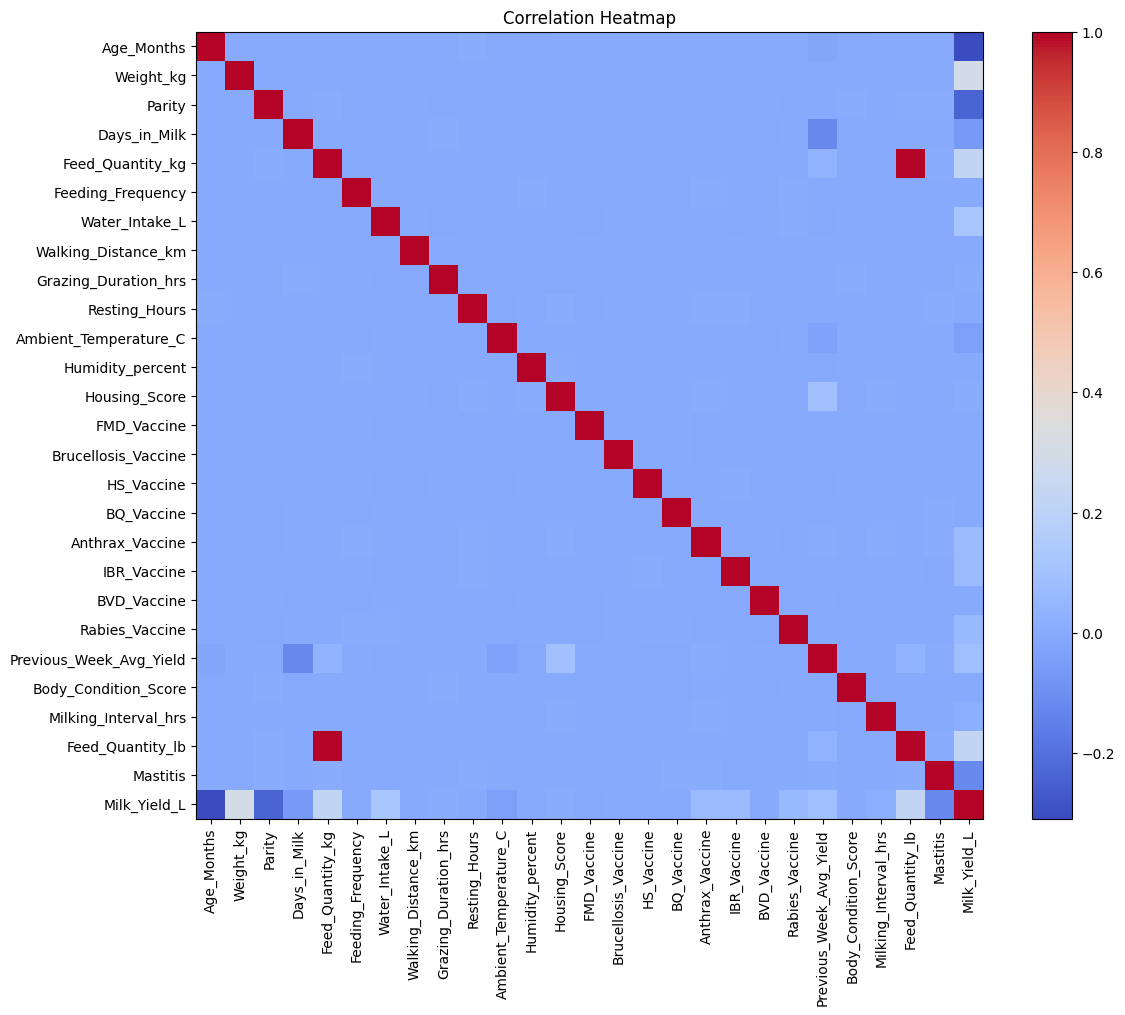

In [205]:

# Here we see that the correlation between housing quality and feed amount
# and all other data is quite low, meaning this would be a poor way to impute the data. 

# we do, however, find that the correlation between Rumination_Time_hrs and Previous_Week_Avg_Yield
# is 1 to 1. This means we can drop one of them and lose no information our model might use. 

data = data.drop(columns=['Rumination_Time_hrs'])


# Select only numeric columns (automatically ignores text columns)
numeric_cols = data.select_dtypes(include=['number'])
numeric_cols = data.select_dtypes(include='number')

# Full correlation matrix
corr_matrix = numeric_cols.corr()

# Print it as a table
print(corr_matrix)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [206]:
# Since previous strategies didn't pan out, we will impute based on 
# the median of the whole dataset. This may be better than the mean since it
# is less resistant to outliers. We also add new columns to mark whether the 
# data has been imputed.  The model may use this to gain some inference on the 
# impact of the imputation. 


data_imputed = data.copy()

data_imputed["housing_missing"] = data_imputed["Housing_Score"].isna().astype(int)
data_imputed["feed_missing"] = data_imputed["Feed_Quantity_kg"].isna().astype(int)

housing_median = data_imputed["Housing_Score"].median()
data_imputed['Housing_Score'] = data_imputed["Housing_Score"].fillna(housing_median)

feed_median = data_imputed["Feed_Quantity_kg"].median()
data_imputed['Feed_Quantity_kg'] = data_imputed["Feed_Quantity_kg"].fillna(feed_median)

data_imputed = data_imputed.drop(columns=['Feed_Quantity_lb'])

print(data_imputed.isna().sum(), data_imputed.head())


Cattle_ID                  0
Breed                      0
Climate_Zone               0
Management_System          0
Age_Months                 0
Weight_kg                  0
Parity                     0
Lactation_Stage            0
Days_in_Milk               0
Feed_Type                  0
Feed_Quantity_kg           0
Feeding_Frequency          0
Water_Intake_L             0
Walking_Distance_km        0
Grazing_Duration_hrs       0
Resting_Hours              0
Ambient_Temperature_C      0
Humidity_percent           0
Housing_Score              0
FMD_Vaccine                0
Brucellosis_Vaccine        0
HS_Vaccine                 0
BQ_Vaccine                 0
Anthrax_Vaccine            0
IBR_Vaccine                0
BVD_Vaccine                0
Rabies_Vaccine             0
Previous_Week_Avg_Yield    0
Body_Condition_Score       0
Milking_Interval_hrs       0
Date                       0
Farm_ID                    0
Mastitis                   0
Milk_Yield_L               0
housing_missin

In [207]:
# according to online, the lactation stages should be defined directly from the days_in_milk.
# Therefore, we are not adding any new information with the Lactation_Stage column.
# Therefore, we will remove it. 

data_imputed = data_imputed.drop(columns=['Lactation_Stage'])
data_imputed = data_imputed.drop(columns=['Cattle_ID'])

# We also drop the ID columns as those can only throw off the model. 
data_imputed = data_imputed.drop(columns=['Farm_ID'])


# We one hot encode the dates by month. Maybe one season/month will produce more milk than another. 
data_imputed['Date'] = pd.to_datetime(data_imputed['Date'])          # convert to datetime
data_imputed['Month'] = data_imputed['Date'].dt.month                # 1–12 integers (or .dt.month_name())
data_imputed = data_imputed.drop(columns=['Date'])

# one-hot encode the month
data_imputed = pd.get_dummies(data_imputed, columns=['Month'], prefix='month', drop_first=False, dtype=int)

In [208]:
data_OHE = data_imputed.copy()
data_OHE = pd.get_dummies(data_OHE, columns=["Breed", "Management_System", "Feed_Type", "Climate_Zone"], drop_first=False, dtype=int)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data_OHE.head()

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Resting_Hours,Ambient_Temperature_C,Humidity_percent,Housing_Score,FMD_Vaccine,Brucellosis_Vaccine,HS_Vaccine,BQ_Vaccine,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Mastitis,Milk_Yield_L,housing_missing,feed_missing,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Breed_Brown Swiss,Breed_Guernsey,Breed_Holstein,Breed_Jersey,Management_System_Extensive,Management_System_Intensive,Management_System_Mixed,Management_System_Pastoral,Management_System_Semi_Intensive,Feed_Type_Concentrates,Feed_Type_Crop_Residues,Feed_Type_Dry_Fodder,Feed_Type_Green_Fodder,Feed_Type_Hay,Feed_Type_Mixed_Feed,Feed_Type_Pasture_Grass,Feed_Type_Silage,Climate_Zone_Arid,Climate_Zone_Continental,Climate_Zone_Mediterranean,Climate_Zone_Subtropical,Climate_Zone_Temperate,Climate_Zone_Tropical
0,114,544.8,4,62,16.363455,2,71.101024,4.77,7.8,12.3,28.706090,70.6,0.871430,0,1,1,0,0,1,0,1,6.31,3.0,12,1,12.192634,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,136,298.9,4,213,12.002254,4,55.697328,5.99,7.4,11.4,28.599741,57.5,0.825488,1,1,0,1,0,0,0,0,17.16,4.0,12,0,14.717031,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,64,336.6,4,16,7.198607,2,65.576827,3.45,8.8,8.6,12.520386,51.2,0.904957,0,0,1,1,0,1,1,0,4.07,3.5,12,0,14.006142,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,58,370.5,1,339,18.694344,2,71.238287,5.95,6.5,10.1,40.510261,57.9,0.324955,1,0,1,0,1,0,0,0,10.23,3.0,24,0,24.324325,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,84,641.5,6,125,14.779198,4,46.979548,5.39,6.4,9.3,-7.711288,73.2,0.871019,0,1,1,1,1,0,1,1,20.68,3.0,12,1,12.023074,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM



# scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_OHE)

# elliptic envelope outlier prediction
ee = EllipticEnvelope(contamination=0.01, random_state=42)
ee_labels = ee.fit_predict(data_scaled)   # +1 = normal, -1 = outlier

# isolation forest outlier prediction
iso = IsolationForest(contamination=0.01, random_state=42)
iso_labels = iso.fit_predict(data_scaled)

# local outlier factor prediction

lof = LocalOutlierFactor(contamination=0.01)
lof_labels = lof.fit_predict(data_scaled)

#SVM outlier prediciton
ocsvm = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale')
ocsvm_labels = ocsvm.fit_predict(data_scaled)



#create table of outliers by function

df_outliers = pd.DataFrame({
    "EllipticEnvelope": ee_labels,
    "IsolationForest": iso_labels,
    "LOF": lof_labels,
    "OneClassSVM": ocsvm_labels
})

# Convert +1/-1 => more intuitive
df_outliers = df_outliers.replace({1: "normal", -1: "outlier"})


outliers_ee = df_outliers[df_outliers["EllipticEnvelope"] == "outlier"].index
outliers_iso = df_outliers[df_outliers["IsolationForest"] == "outlier"].index
outliers_lof = df_outliers[df_outliers["LOF"] == "outlier"].index
outliers_svm = df_outliers[df_outliers["OneClassSVM"] == "outlier"].index


df_outliers["votes"] = (
    (df_outliers == "outlier").sum(axis=1)
)

consensus_outliers = df_outliers[df_outliers["votes"] >= 2].index